# Relog.kz Algorithm Assignment
## Author: Ayan Ashkenov
## Date: 21/11/2021
## Description:
Given a json file containing coordinate locations, a distance matrix, and K value,  
write a clustering algorithm and display the results in visual form. The algorithm  
cannot run for more than 5 minutes (maximum distance matrix size 5,000 x 5,000).  
  
Unsure if allowed to use popular ML libraries, I recreated the widely used K-means  
algorithm. My solution is a naive K-means, not the more sophisticated K-means++ due  
to time contraints. I assumed that the chance of my K-means imitation getting stuck  
in a local minimum is fairly low (this may or may not be true; future improvements  
should address this question thoroughly).

### Imports

In [1]:
import random
import json
from statistics import mean

import numpy as np
import pandas as pd

from sklearn.metrics import pairwise_distances

import matplotlib.pyplot as plt
import folium

### Helper functions
The K-means algorithm can be divided into several stages. First, initialize starting  
centroids. Second, calculate the distance between these centroids and all other data  
points. Third, cluster the data based on these distances. Fourth, revise the centroids  
and repeat the process until cluster assignment does not change.  
  
The functions below address these steps and make up the final K-means function.

In [2]:
def get_initial_centroids(matrix: np.ndarray, K: int):
    return np.asarray(random.sample(population=matrix, k=K))

def assign_clusters(matrix: np.ndarray, centroids: np.ndarray, metric: str = 'manhattan'):
    dist_from_centroids: np.ndarray = pairwise_distances(
        X=matrix, 
        Y=centroids, 
        metric=metric,
    )
    return np.argmin(a=dist_from_centroids, axis=1)

def revise_centroids(matrix: np.ndarray, K: int, cluster_assignment: np.ndarray):
    new_centroids: list = []
    for cluster in range(K):
        cluster_members: np.ndarray = matrix[cluster_assignment==cluster]
        centroid: float = cluster_members.mean(axis=0)
        centroid = centroid.flatten()
        new_centroids.append(centroid)
    return np.array(new_centroids)

def compute_heterogeneity(
    matrix: np.ndarray, 
    K: int, 
    centroids: np.ndarray, 
    cluster_assignment: np.ndarray, 
    metric: str = 'manhattan'
):
    heterogeneity: int = 0
    for cluster in range(K):
        cluster_members: np.ndarray = matrix[cluster_assignment==cluster]
        if cluster_members.shape[0] > 0:
            distances: np.ndarray = pairwise_distances(
                X=cluster_members, 
                Y=[centroids[cluster]], 
                metric=metric,
            )
            squared_distances: np.ndarray = distances**2
            heterogeneity += np.sum(squared_distances)
    return heterogeneity

#### The algorithm: K-means imitation

In [3]:
def kmeans(matrix: list, K: int, max_iterations: int = 100, record_heterogeneity = None):
    centroids: np.ndarray = get_initial_centroids(matrix=matrix, K=K)
    prev_cluster_assignment = None
    transformed_matrix: np.ndarray = np.asarray(matrix)
    
    for iteration in range(max_iterations):
        cluster_assignment: np.ndarray = assign_clusters(
            matrix=matrix, 
            centroids=centroids,
        ) 
        centroids: np.ndarray = revise_centroids(
            matrix=transformed_matrix, 
            K=K, 
            cluster_assignment=cluster_assignment,
        ) 
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment==cluster_assignment).all():
            break        
        if record_heterogeneity is not None:
            score: float = compute_heterogeneity(
                matrix=transformed_matrix, 
                K=K, 
                centroids=centroids, 
                cluster_assignment=cluster_assignment,
            )
            record_heterogeneity.append(score)        
        prev_cluster_assignment = cluster_assignment
                
    return centroids, cluster_assignment, heterogeneity

### Load and open the JSON file(s)

In [4]:
json_file_path: str = 'test3.json'
with open(file=json_file_path, mode='r') as json_opener:
     json_contents = json.loads(json_opener.read())

test_matrix: list = json_contents['matrix']
test_locations: list = json_contents['locations']
K: int = json_contents['K']
heterogeneity: list = []

### Run the algorithm
The algorithm returns 3 results: centroid "coordinates", cluster_assignments in the form  
of a np.ndarray, and heterogeneity values as a list.

In [5]:
centroids, cluster_assignment, heterogeneity = kmeans(
    matrix=test_matrix, 
    K=K, 
    max_iterations=50, 
    record_heterogeneity=heterogeneity,
)

#### Plot heterogeneity
To make sure that the clusters are getting "tighter", I plot heterogeneity  
over the number of iterations. The K-means algorithm should theoretically  
converge, but it is always better to make sure.  
  
Heterogeneity is defined as the sum of squared distances between centroids  
and data points. The smaller the value, the "tighter" the cluster are.

Text(0.5, 1.0, 'Heterogeneity over iterations')

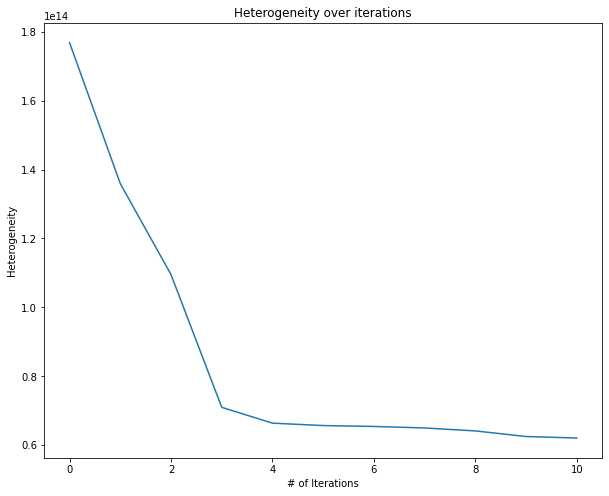

In [6]:
plt.figure(figsize=(10, 8))
plt.plot(heterogeneity)
plt.xlabel('# of Iterations')
plt.ylabel('Heterogeneity')
plt.title('Heterogeneity over iterations')

As is observed in the above plot, the heterogeneity of the clusters does go  
down with iterations. This means that our clusters are getting "tighter",  
which is good.

### Visualize clusters
First, we need to extract latitude and longitude values from  
the JSON. Then we display a plot with the algorithm results.

In [7]:
def latitude_mapper(location: dict):
    return location['lat']

def longitude_mapper(location: dict):
    return location['lng']

latitude: list = list(map(latitude_mapper, test_locations))
longitude: list = list(map(longitude_mapper, test_locations))

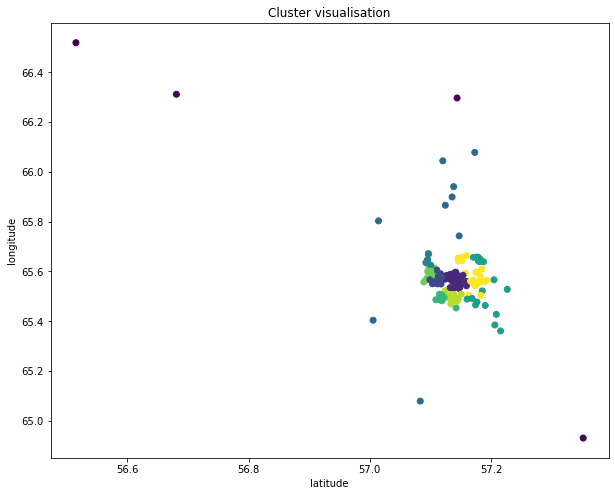

In [8]:
plt.figure(figsize=(10,8))
plt.title('Cluster visualisation')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.scatter(x=latitude, y=longitude, c=cluster_assignment)
plt.show()

In [9]:
locations_map: folium.Map = folium.Map(
    location=[mean(latitude), mean(longitude)], 
    zoom_start=10,
)

colors: list = [
    'red', 'blue', 
    'green', 'purple', 
    'orange', 'pink', 
    'black', 'darkgreen', 
    'cadetblue', 'darkpurple',
]

for lat, lng, cluster in zip(latitude, longitude, cluster_assignment):
    label: folium.Popup = folium.Popup('Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        location=[lat, lng],
        radius=3,
        popup=label,
        color=colors[cluster],
    ).add_to(locations_map)
       
locations_map